<a href="https://colab.research.google.com/github/Morilla123/Curso/blob/main/cnn_deteccion_fichas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import TensorFlow and other libraries

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Data

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
!ls '/content/drive/MyDrive/Colab Notebooks/data peru cnn' 

'ficha 1'  'ficha 1.rar'   no-ficha   no-ficha.rar


In [11]:
!unrar e '/content/drive/MyDrive/Colab Notebooks/data peru cnn/ficha 1.rar' -d '/content/drive/MyDrive/Colab Notebooks/data peru cnn/ficha 1'
!unrar e '/content/drive/MyDrive/Colab Notebooks/data peru cnn/no-ficha.rar' -d '/content/drive/MyDrive/Colab Notebooks/data peru cnn/no-ficha'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/Colab Notebooks/data peru cnn/ficha 1.rar


Would you like to replace the existing file /content/drive/MyDrive/Colab Notebooks/data peru cnn/ficha 1/00014-2021-0-0401-JR-FT-05 - EXPEDIENTE.pdf0001-10.jpg
483666 bytes, modified on 2021-12-29 10:19
with a new one
483666 bytes, modified on 2021-12-29 10:19

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit N


Would you like to replace the existing file /content/drive/MyDrive/Colab Notebooks/data peru cnn/ficha 1/00114-2021-0-0401-JR-FT-05 - EXPEDIENTE.pdf0001-12.jpg
504095 bytes, modified on 2021-12-29 10:03
with a new one
504095 bytes, modified on 2021-12-29 10:03

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit A

Extracting  /content/drive/MyDrive/Colab Notebooks/data peru cnn/ficha 1/00114-2021-0-0401-JR-FT-05 - EXPEDIENTE.pdf0001-12.jpg       1%  OK 
Extracting  /content/drive/MyDrive/Colab Notebooks/data peru cnn/ficha 1/0

## Create dataset


In [12]:
# Sujeto a modificacion
batch_size = 32
img_height = 180
img_width = 180

In [13]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/data peru cnn/'

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,  #direccion del dataset
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 200 files belonging to 2 classes.
Using 160 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 200 files belonging to 2 classes.
Using 40 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['ficha 1', 'no-ficha']


## Visualize the data

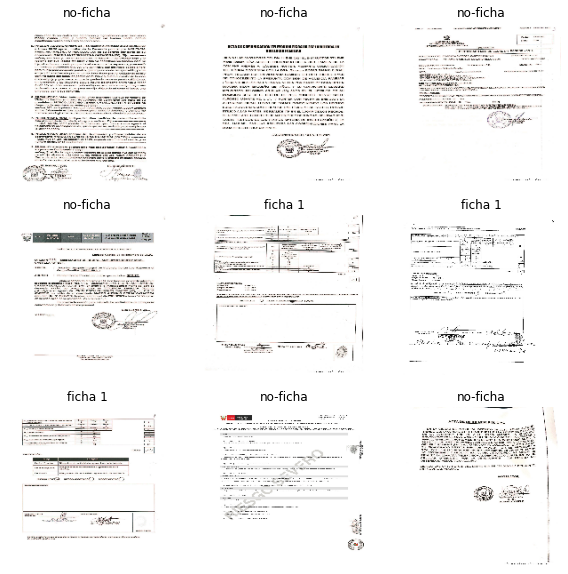

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Configure the dataset for performance
Asegurémonos de utilizar la captación previa almacenada en búfer para que pueda obtener datos del disco sin que la E/S se convierta en un bloqueo. Estos son dos métodos importantes que debe usar al cargar datos:

* Dataset.cache mantiene las imágenes en la memoria después de que se cargan fuera del disco durante la primera época. Esto asegurará que el conjunto de datos no se convierta en un cuello de botella mientras entrena su modelo. Si su conjunto de datos es demasiado grande para caber en la memoria, también puede usar este método para crear un caché en disco de alto rendimiento.
* Dataset.prefetch superpone el preprocesamiento de datos y la ejecución del modelo durante el entrenamiento.
Los lectores interesados pueden obtener más información sobre ambos métodos, así como sobre cómo almacenar datos en caché en el disco, en la sección Precarga de la guía Mejor rendimiento con la API tf.data.

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [20]:
normalization_layer = layers.Rescaling(1./255)

In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.015304194 1.0


## Data Agumentation

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

## Create the model

In [24]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

In [ ]:
model.summary()

## Train the model

In [26]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
5/5 [==============================] - 9s 2s/step - loss: 2.1356 - accuracy: 0.4313 - val_loss: 0.6978 - val_accuracy: 0.5000
Epoch 2/15
5/5 [==============================] - 6s 1s/step - loss: 0.8014 - accuracy: 0.4500 - val_loss: 0.7006 - val_accuracy: 0.5000
Epoch 3/15
5/5 [==============================] - 6s 1s/step - loss: 0.6968 - accuracy: 0.5000 - val_loss: 0.6899 - val_accuracy: 0.5000
Epoch 4/15
5/5 [==============================] - 6s 1s/step - loss: 0.7068 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 5/15
5/5 [==============================] - 6s 1s/step - loss: 0.7004 - accuracy: 0.5375 - val_loss: 0.7059 - val_accuracy: 0.5000
Epoch 6/15
5/5 [==============================] - 6s 1s/step - loss: 0.7003 - accuracy: 0.4750 - val_loss: 0.6914 - val_accuracy: 0.5250
Epoch 7/15
5/5 [==============================] - 6s 1s/step - loss: 0.6924 - accuracy: 0.4938 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 8/15
5/5 [=========================

## Visualize training results

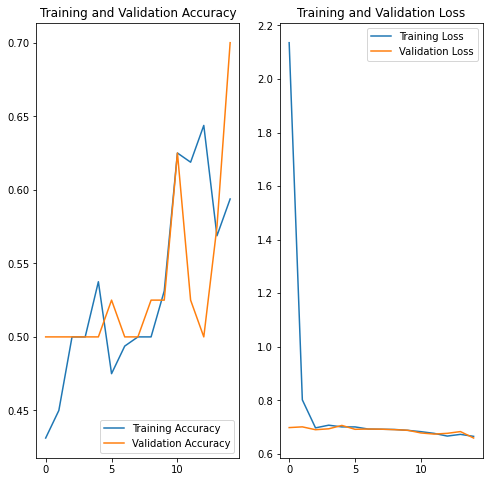

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [ ]:
img = 

In [ ]:
predictions = model.predict(img)
score = tf.nn.softmax(predictions[0])